In [ ]:
import numpy as np
import tensorflow as tf

# Parameters
NUM_CLASSES = 3
INPUT_SIZE = 250
BATCH_SIZE = 32
EPOCHS = 10
MAX_OBJECTS = 10

# Create synthetic data
def create_synthetic_dataset(num_samples):
    images = np.random.random((num_samples, INPUT_SIZE, INPUT_SIZE, 3)).astype(np.float32)
    bboxes = np.random.random((num_samples, MAX_OBJECTS, 4)).astype(np.float32)
    class_ids = np.zeros((num_samples, MAX_OBJECTS, NUM_CLASSES), dtype=np.float32)
    for i in range(num_samples):
        for j in range(MAX_OBJECTS):
            class_ids[i, j, np.random.randint(0, NUM_CLASSES)] = 1.0
    return images, bboxes, class_ids

# Create synthetic train and validation datasets
train_images, train_bboxes, train_class_ids = create_synthetic_dataset(100)
val_images, val_bboxes, val_class_ids = create_synthetic_dataset(20)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_bboxes, train_class_ids)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_bboxes, val_class_ids)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Debug statements to check shapes
for images, bboxes, class_ids in train_ds.take(1):
    print(f"Train Images shape: {images.shape}")
    print(f"Train Bounding boxes shape: {bboxes.shape}")
    print(f"Train Class IDs shape: {class_ids.shape}")


In [ ]:
from tensorflow.keras import layers, models

def build_simplified_model(input_size, num_classes, max_objects):
    inputs = tf.keras.Input(shape=(input_size, input_size, 3))
    
    # Simple feature extractor
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    
    # Bounding box predictions for each object (4 coordinates per object)
    bbox_output = layers.Dense(max_objects * 4)(x)
    bbox_output = layers.Reshape((max_objects, 4), name='bbox_output')(bbox_output)
    
    # Class predictions for each object (num_classes per object)
    class_output = layers.Dense(max_objects * num_classes, activation='sigmoid')(x)
    class_output = layers.Reshape((max_objects, num_classes), name='class_output')(class_output)
    
    model = models.Model(inputs=inputs, outputs=[bbox_output, class_output])
    return model

# Build the model
model = build_simplified_model(INPUT_SIZE, NUM_CLASSES, MAX_OBJECTS)
model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_bbox_loss(y_true, y_pred):
    # Ensure y_true and y_pred are of shape (batch_size, MAX_OBJECTS, 4)
    return tf.reduce_mean(tf.square(y_pred - y_true), axis=[1, 2])

def custom_class_loss(y_true, y_pred):
    # Ensure y_true and y_pred are of shape (batch_size, MAX_OBJECTS, NUM_CLASSES)
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=[1, 2])


# Compile the model with simplified custom loss functions
model.compile(
    optimizer='adam',
    loss={
        'bbox_output': custom_bbox_loss,
        'class_output': custom_class_loss
    },
    metrics={
        'bbox_output': 'mean_squared_error',
        'class_output': 'accuracy'
    }
)


# Train the model using model.fit
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
)


Epoch 1, Loss: 0.7016085982322693, Val Loss: 0.6940540838986635
Epoch 2, Loss: 0.6738392114639282, Val Loss: 0.6833688076585531
Epoch 3, Loss: 0.672019362449646, Val Loss: 0.6788584087044001
Epoch 4, Loss: 0.6609793901443481, Val Loss: 0.675440376624465
Epoch 5, Loss: 0.6554042100906372, Val Loss: 0.6694768909364939
Epoch 6, Loss: 0.6372829675674438, Val Loss: 0.667609172873199
Epoch 7, Loss: 0.6400445699691772, Val Loss: 0.6672608498483896
Epoch 8, Loss: 0.6234586238861084, Val Loss: 0.666862484999001
Epoch 9, Loss: 0.6102792024612427, Val Loss: 0.6655621323734522
Epoch 10, Loss: 0.5991848111152649, Val Loss: 0.6616466529667377
Epoch 11, Loss: 0.5796732306480408, Val Loss: 0.6614896468818188
Epoch 12, Loss: 0.5620319843292236, Val Loss: 0.6583632417023182
Epoch 13, Loss: 0.5811127424240112, Val Loss: 0.6625438220798969
Epoch 14, Loss: 0.5613498687744141, Val Loss: 0.6670778915286064
Epoch 15, Loss: 0.5662481784820557, Val Loss: 0.6713621560484171
Epoch 16, Loss: 0.5417947769165039, Va

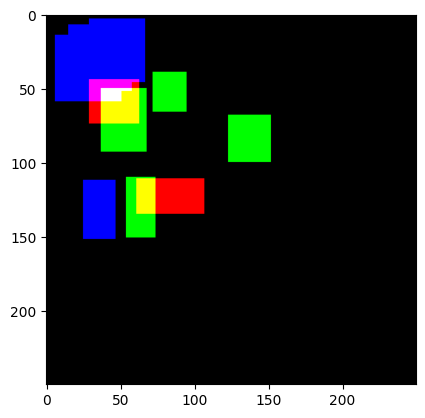

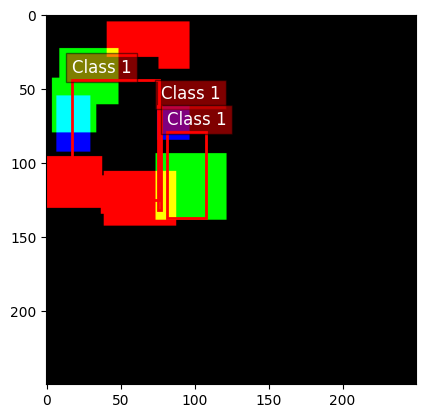

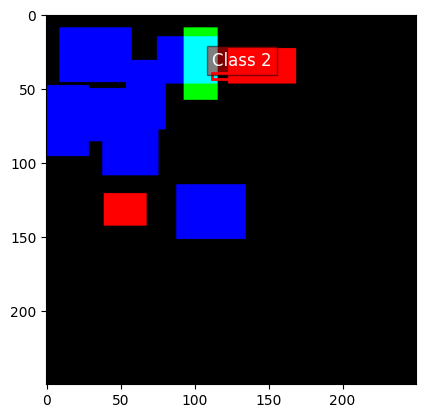

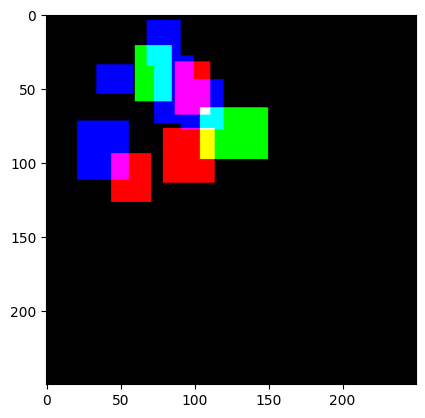

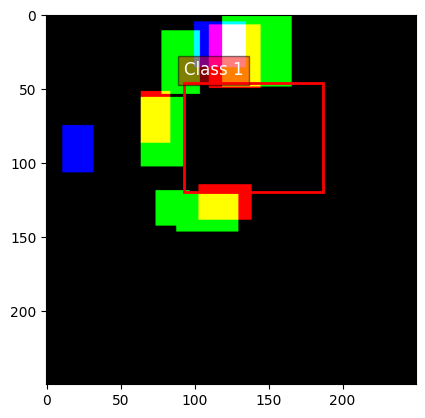

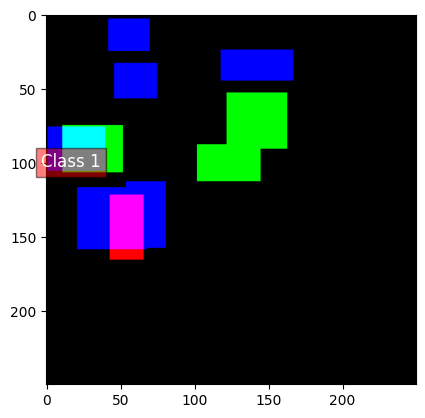

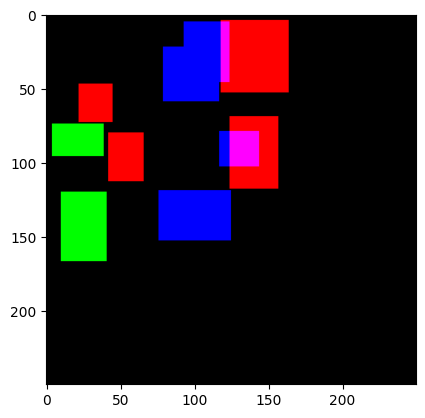

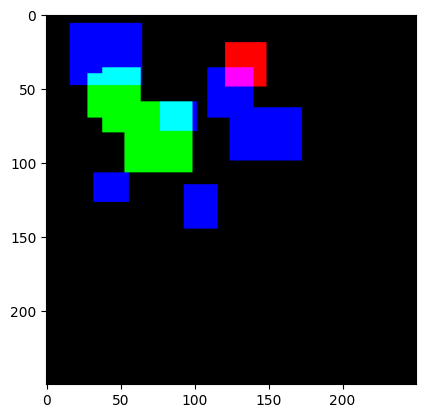

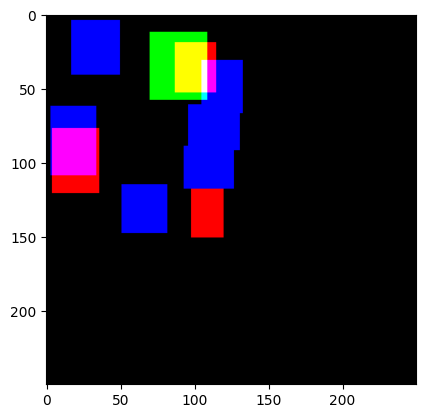

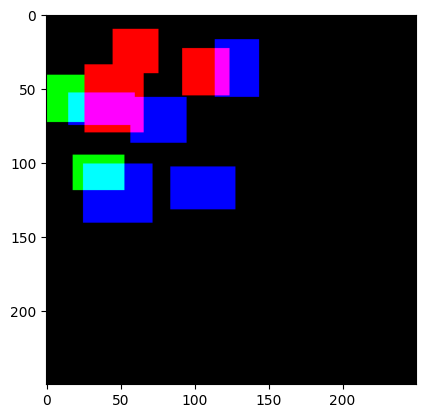

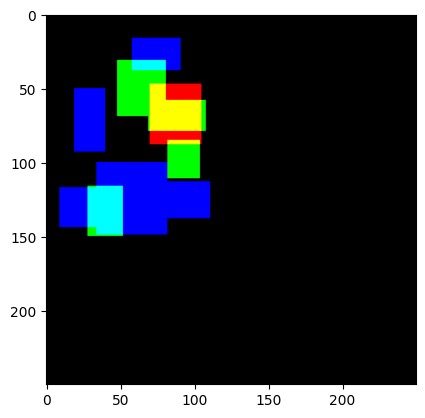

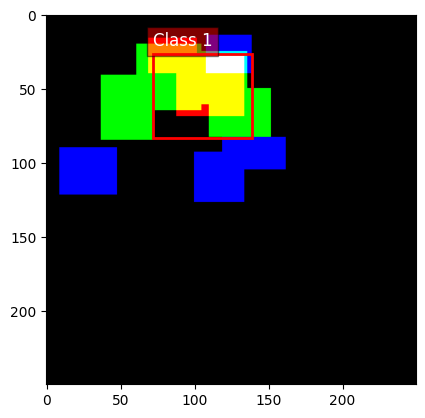

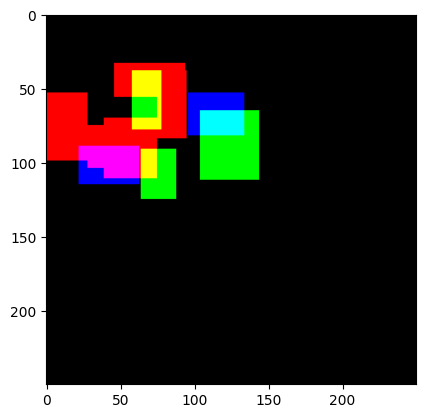

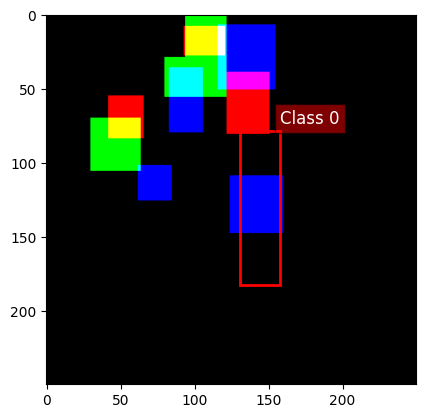

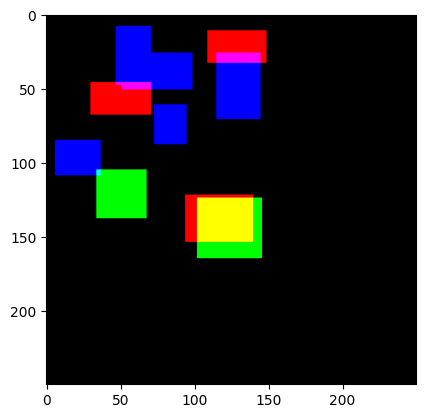

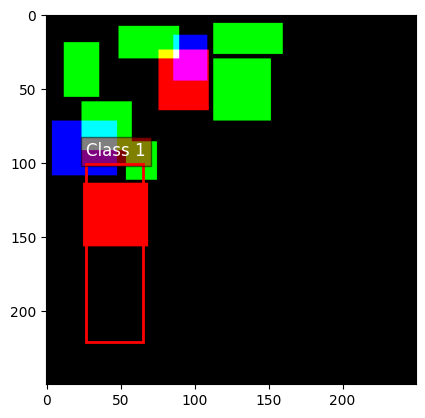

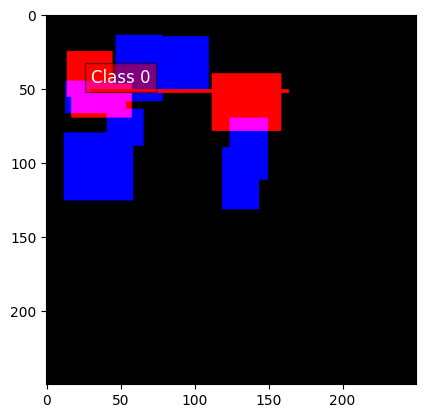

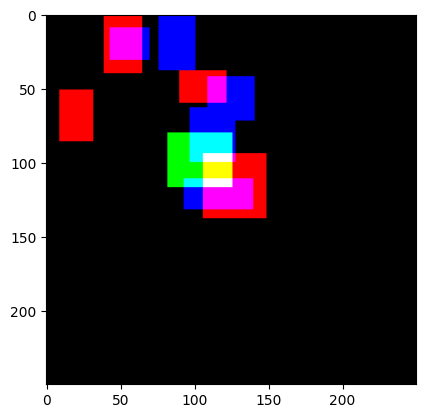

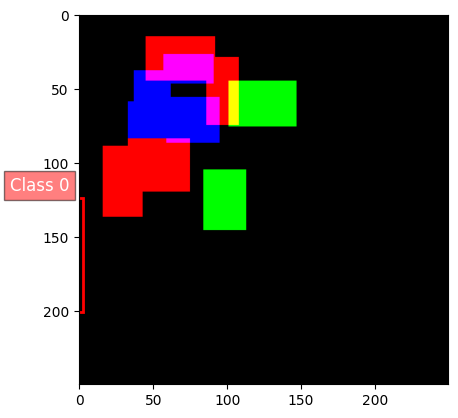

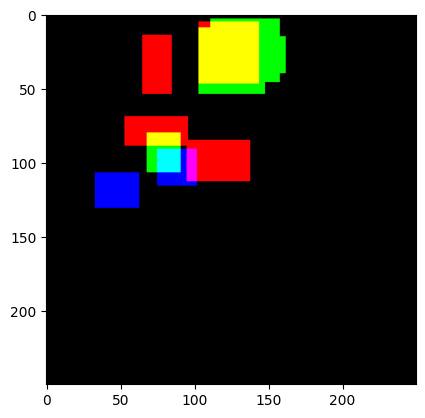

In [58]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Parameters
NUM_CLASSES = 3
INPUT_SIZE = 250
BATCH_SIZE = 32
EPOCHS = 20
MAX_OBJECTS = 10
LEARNING_RATE = 0.0001

# Create synthetic dataset
class SyntheticDataset(Dataset):
    def __init__(self, num_samples, input_size, max_objects, num_classes):
        self.num_samples = num_samples
        self.input_size = input_size
        self.max_objects = max_objects
        self.num_classes = num_classes
        self.transform = T.Compose([T.ToTensor()])
        self.images, self.bboxes, self.class_ids = self.create_synthetic_dataset()

    def create_synthetic_dataset(self):
        images = np.zeros((self.num_samples, self.input_size, self.input_size, 3), dtype=np.float32)
        bboxes = np.zeros((self.num_samples, self.max_objects, 4), dtype=np.float32)
        class_ids = np.zeros((self.num_samples, self.max_objects, self.num_classes), dtype=np.float32)
        for i in range(self.num_samples):
            for j in range(self.max_objects):
                class_id = np.random.randint(0, self.num_classes)
                x1, y1 = np.random.randint(0, self.input_size // 2, size=2)
                x2, y2 = x1 + np.random.randint(20, 50), y1 + np.random.randint(20, 50)
                images[i, y1:y2, x1:x2, class_id] = 1.0
                bboxes[i, j] = [x1 / self.input_size, y1 / self.input_size, (x2 - x1) / self.input_size, (y2 - y1) / self.input_size]
                class_ids[i, j, class_id] = 1.0
        return images, bboxes, class_ids

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = self.images[idx]
        bboxes = self.bboxes[idx]
        class_ids = self.class_ids[idx]
        image = self.transform(image)
        return image, bboxes, class_ids

# Create datasets and dataloaders
train_dataset = SyntheticDataset(100, INPUT_SIZE, MAX_OBJECTS, NUM_CLASSES)
val_dataset = SyntheticDataset(20, INPUT_SIZE, MAX_OBJECTS, NUM_CLASSES)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define model
class ObjectDetectionModel(nn.Module):
    def __init__(self, num_classes, num_anchors):
        super(ObjectDetectionModel, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128 * (INPUT_SIZE // 8) * (INPUT_SIZE // 8), 256),
            nn.ReLU()
        )
        
        self.bbox_head = nn.Linear(256, num_anchors * 4)
        self.class_head = nn.Linear(256, num_anchors * num_classes)

    def forward(self, x):
        x = self.features(x)
        bboxes = self.bbox_head(x).view(-1, self.num_anchors, 4)
        class_logits = self.class_head(x).view(-1, self.num_anchors, self.num_classes)
        return bboxes, class_logits

model = ObjectDetectionModel(NUM_CLASSES, MAX_OBJECTS)

# Define loss functions
def bbox_loss_fn(pred_bboxes, true_bboxes):
    return nn.functional.mse_loss(pred_bboxes, true_bboxes)

def class_loss_fn(pred_class_logits, true_class_ids):
    return nn.functional.binary_cross_entropy_with_logits(pred_class_logits, true_class_ids)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    for images, true_bboxes, true_class_ids in train_loader:
        optimizer.zero_grad()
        pred_bboxes, pred_class_logits = model(images)
        
        bbox_loss = bbox_loss_fn(pred_bboxes, true_bboxes)
        class_loss = class_loss_fn(pred_class_logits, true_class_ids)
        
        loss = bbox_loss + class_loss
        loss.backward()
        optimizer.step()
    
    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, true_bboxes, true_class_ids in val_loader:
            pred_bboxes, pred_class_logits = model(images)
            
            bbox_loss = bbox_loss_fn(pred_bboxes, true_bboxes)
            class_loss = class_loss_fn(pred_class_logits, true_class_ids)
            
            val_loss += bbox_loss.item() + class_loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Val Loss: {val_loss / len(val_loader)}")

# Visualization function
def visualize_predictions(images, pred_bboxes, pred_class_logits):
    images = images.permute(0, 2, 3, 1).cpu().numpy()
    pred_bboxes = pred_bboxes.cpu().detach().numpy()
    pred_class_logits = pred_class_logits.cpu().detach().numpy()
    pred_class_ids = np.argmax(pred_class_logits, axis=-1)
    
    for i in range(images.shape[0]):
        plt.imshow(images[i])
        for j in range(pred_bboxes.shape[1]):
            bbox = pred_bboxes[i, j]
            class_id = pred_class_ids[i, j]
            if np.max(pred_class_logits[i, j]) > 0.5:  # Only show high-confidence predictions
                plt.gca().add_patch(plt.Rectangle(
                    (bbox[0] * INPUT_SIZE, bbox[1] * INPUT_SIZE),
                    bbox[2] * INPUT_SIZE,
                    bbox[3] * INPUT_SIZE,
                    fill=False,
                    edgecolor='red',
                    linewidth=2
                ))
                plt.text(
                    bbox[0] * INPUT_SIZE,
                    bbox[1] * INPUT_SIZE - 5,
                    f'Class {class_id}',
                    bbox=dict(facecolor='red', alpha=0.5),
                    fontsize=12,
                    color='white'
                )
        plt.show()

# Visualize predictions on validation set
model.eval()
with torch.no_grad():
    for images, true_bboxes, true_class_ids in val_loader:
        pred_bboxes, pred_class_logits = model(images)
        visualize_predictions(images, pred_bboxes, pred_class_logits)
        break  # Visualize only the first batch


In [ ]:
train_dataset = CustomDataset('../yolo_data_v2/train/images', '../yolo_data_v2/train/labels', INPUT_SIZE, NUM_CLASSES, MAX_OBJECTS, transform)
val_dataset = CustomDataset('../yolo_data_v2/val/images', '../yolo_data_v2/val/labels', INPUT_SIZE, NUM_CLASSES, MAX_OBJECTS, transform)